### Importación de la librería

In [1]:
from PIL import Image
import pytesseract
import cv2
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt



In [2]:
image = Image.open("factura0.jpg")

In [3]:

def pil_to_cv2(image):
    return cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)

def cv2_to_pil(image):
    return Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

def to_string(image):
    return pytesseract.image_to_string(image)

def show_image_with_matplotlib(image, title="Image", size=(5, 5)):
    plt.figure(figsize=size)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis('off')
    plt.show()


In [4]:
image_cv2 = pil_to_cv2(image)
image_gray = cv2.cvtColor(image_cv2, cv2.COLOR_BGR2GRAY)
image_pil = cv2_to_pil(image_gray)


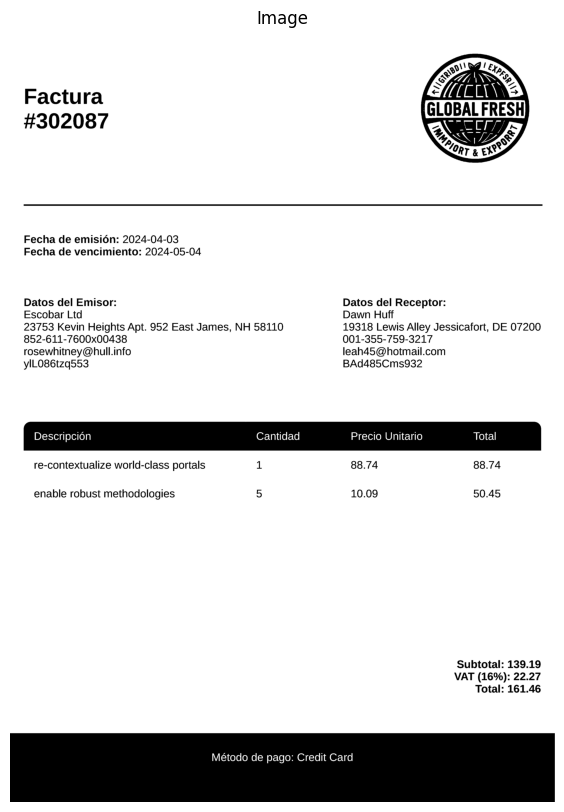

In [5]:
# Apply binary thresholding
image_binary = cv2.threshold(image_gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

show_image_with_matplotlib(image_binary, size=(10, 10))


In [6]:
text = to_string(image_pil)
print(text)

Factura
#302087

Fecha de emision: 2024-04-03
Fecha de vencimiento: 2024-05-04

Datos del Emisor:

Escobar Ltd

23753 Kevin Heights Apt. 952 East James, NH 58110
852-611-7600x00438

rosewhitney@hull.info

ylL086tz(q553

Datos del Receptor:

Dawn Huff

19318 Lewis Alley Jessicafort, DE 07200
001-355-759-3217

leah45@hotmail.com

BAd485Cms932

Precio Unitario

Descripcion Cantidad
re-contextualize world-class portals 1
enable robust methodologies 5

88.74 88.74

10.09 50.45

Subtotal: 139.19
VAT (16%): 22.27
Total: 161.46

Método de pago: Credit Card




### Aplicado de las bounding boxes

In [7]:

## Función para el pipeline para la extracción de filas de una tabla
def merge_boxes_on_same_row(boxes, y_threshold):
    # Ordenar las bounding boxes por la coordenada y
    boxes.sort(key=lambda b: b[1])

    def get_y_center(box):
        _, y, _, h = box
        return y + h // 2

    # Agrupar las bounding boxes
    grouped_boxes = []
    current_group = []

    for box in boxes:
        if not current_group:
            current_group.append(box)
        else:
            last_box = current_group[-1]
            if abs(get_y_center(box) - get_y_center(last_box)) <= y_threshold:
                current_group.append(box)
            else:
                # Si no se agrupan, comprobar si el grupo actual tiene 4 o más elementos
                if len(current_group) >= 4:
                    grouped_boxes.append(current_group)
                current_group = [box]

    # Comprobar el último grupo
    if len(current_group) >= 4:
        grouped_boxes.append(current_group)

    # Crear nuevas bounding boxes agrupadas
    merged_boxes = []
    for group in grouped_boxes:
        x_min = min(box[0] for box in group)
        y_min = min(box[1] for box in group)
        x_max = max(box[0] + box[2] for box in group)
        y_max = max(box[1] + box[3] for box in group)
        merged_boxes.append((x_min, y_min, x_max - x_min, y_max - y_min))

    # Incluir las cajas que no fueron agrupadas
    all_grouped_boxes = sum(grouped_boxes, [])
    for box in boxes:
        if box not in all_grouped_boxes:
            merged_boxes.append(box)
    
    # Ordenar las bounding boxes por la coordenada y
    merged_boxes.sort(key=lambda b: b[1])

    return merged_boxes


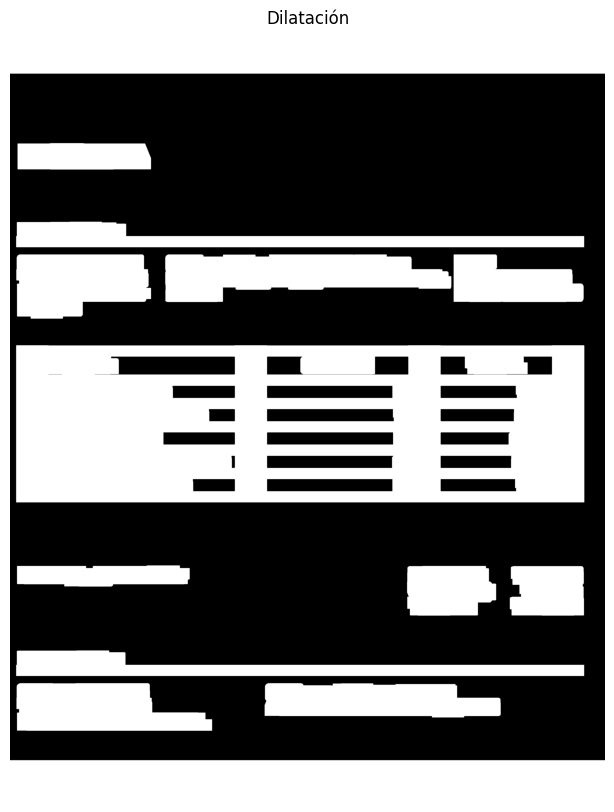

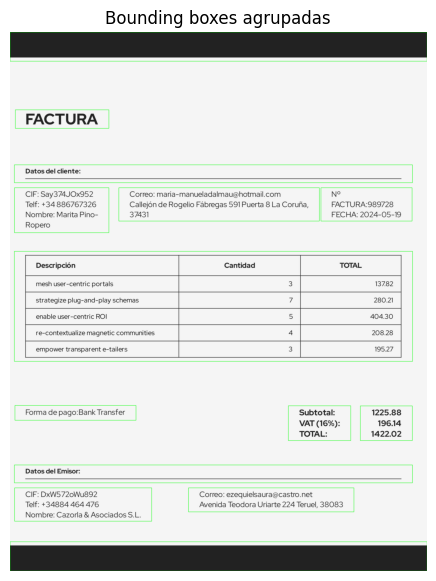


FACTURA

Datos del cliente:

NO
FACTURA:989728
FECHA: 2024-05-19

Correo: maria-manueladalmau@hotmail.com
Callejon de Rogelio Fabregas 591 Puerta 8 La Coruia,
37431

CIF: Say374J0x952
Telf: +34 886767326
Nombre: Marita Pino-
Ropero


Forma de pago:Bank Transfer

Subtotal:
VAT (16%):
TOTAL.:

1225.88
196.14
1422.02

Datos del Emisor:

Correo: ezequielsaura@castro.net
Avenida Teodora Uriarte 224 Teruel, 38083

CIF: DxXW5720Wu892
Telf: +34884 464 476
Nombre: Cazorla & Asociados S.L.




In [9]:
## Cargamos la imagen en escala de grises original


image = cv2.imread("facturas/fbbfaf0b-3b74-4ef6-88bf-3e63a4fab330.jpg")
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

blur = cv2.GaussianBlur(gray, (7, 7), 0)


thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]


kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (13,5))

dilate = cv2.dilate(thresh, kernel, iterations=15)
show_image_with_matplotlib(dilate, title="Dilatación", size=(10, 10))

cnts = cv2.findContours(dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

cnts = cnts[0] if len(cnts) == 2 else cnts[1]

boxes = [cv2.boundingRect(c) for c in cnts]

# Agrupar las bounding boxes que están a la misma altura
y_threshold = 10  # Definir el umbral de altura
grouped_boxes = merge_boxes_on_same_row(boxes, y_threshold)

# Dibujar las bounding boxes agrupadas en la imagen
for (x, y, w, h) in grouped_boxes:
    cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

# Mostrar la imagen con las bounding boxes agrupadas

show_image_with_matplotlib(image, title="Bounding boxes agrupadas", size=(7, 7))
# Pasarle OCR a las bounding boxes agrupadas
for (x, y, w, h) in grouped_boxes:
    roi = gray[y:y+h, x:x+w]
    text = pytesseract.image_to_string(roi, config='--psm 6')
    print(text)




##Display the image with bounding box
#display(cv2_to_pil(image))

